    我国股票市场作为证券市场的核心组成部分，已成为推动社会主义市场经济发展的重要力量，为资本配置优化、企业融资拓展及经济增长注入了关键动能。然而，相较于西方历经百年发展的成熟股票市场，我国股市因发展历程较短，在市场机制、投资者结构等方面仍存在待改进与完善之处，非理性市场现象时有显现。
    从行为金融学视角来看，市场中多数投资者的决策行为存在非理性特征：部分投资者易受市场舆论、短期波动等外部因素影响，盲目跟从市场风向（即 “羊群效应”），缺乏对企业基本面、行业趋势的独立理性分析，导致投资决策偏离客观价值判断。而现有研究已明确，投资者情绪并非个体心理的孤立体现，而是影响资本市场资产定价的系统性因素 —— 其波动会通过投资者的非理性交易行为传导至市场，进而对股票价格与收益率产生显著作用。
    基于此，本项目聚焦 “投资者情绪指标与股票收益率的关联机制” 展开研究，旨在搞清楚投资者情绪对股票收益率的影响方向、强度及作用路径。

In [ ]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates


from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family'] = 'Times New Roman'


#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

指标计算涵盖以下两类：
封闭式基金数据（基金收盘价、单位净值、份额）、IPO 数据（发行数量、流通股数、首日收盘价、发行价）
来源于清华大学中国金融研究中心（CCFR）；
交易量（日交易量、日流通市值）、消费者信心指数（CCI）、新增投资者开户数（NIA）
来源于《中国经济景气月报》。


查看数据

In [8]:
from pandas.tseries.offsets import MonthEnd # 月末
QX_ISI = pd.read_excel('QX_ISI.xlsx')
QX_ISI.set_index('month', inplace=True)#设置索引为月份

QX_ISI


,DCEF,RIPO,NIPO,NA,TURN,CCI,ISI,StdISI,StdExMacroISI
month,,,,,,,,,
统计月度,上月封闭基金平均折价率,IPO首日收益率均值,IPO数,新增开户数,上月市场换手率,上月消费者信心,投资者情绪指数,投资者情绪指数(标准化),投资者情绪指数(标准化-剔除宏观经济因素)
2003-01,-0.1034,0.905,5,3.97,0.1054,97.5,26.44,-1.23,-1.21
2003-02,-0.1117,0.7691,3,2.85,0.1928,97.7,25.3,-1.02,-0.98
2003-03,-0.0941,0.6831,6,3.26,0.1328,97.8,26.2,-1.23,-1.24
2003-04,-0.1399,1.1853,5,5.69,0.1218,97.6,27.69,-1.05,-0.97
...,...,...,...,...,...,...,...,...,...
2023-02,0.0422,0.5563,24,55.89,0.2111,91.2,62.49,0.37,-0.02
2023-03,0.0105,0.2639,34,63.21,0.2311,94.7,70.1,0.48,0.04
2023-04,0.0408,0.4279,35,33.4,0.2377,94.9,51.39,0.28,-0.17


指标名称（英文缩写）	    核心作用
封闭式基金折价率（DCEF）	捕捉市场对资产价值的非理性预期偏差
交易量指标（TURN）	        剔除市场规模扩张干扰，反映投资者参与程度与交易活跃度
IPO 数量（IPON）	       体现 “热市发行” 现象，反映市场对新股的追捧程度
IPO 首日收益率（IPOR）	    捕捉市场短期乐观情绪，反映对新股的非理性追捧
消费者信心指数（CCI）	    补充主观情绪维度，反映经济预期对投资者乐观程度的传导效应
新增投资者开户数（NIA）	    反映增量资金入场节奏与投资者对股市的长期预期

In [9]:

# 检查数据类型，确保都是数字
print("数据列类型检查：")
print(QX_ISI[['DCEF', 'RIPO', 'NIPO', 'NA', 'TURN', 'CCI']].dtypes)

# 将列转换为数值类型（pd.to_numeric 会自动处理非数字）
columns = ['DCEF', 'RIPO', 'NIPO', 'NA', 'TURN', 'CCI']
for col in columns:
    if col in QX_ISI.columns:
        QX_ISI[col] = pd.to_numeric(QX_ISI[col], errors='coerce')  # errors='coerce' 将非数字转为 NaN

print("\n转换后数据类型：")
print(QX_ISI[columns].dtypes)

# 提取各列数据
DCEF = QX_ISI['DCEF']  # 上月封闭基金平均折价率
RIPO = QX_ISI['RIPO']  # 开通股票新增开户数
NIPO = QX_ISI['NIPO']  # 月度新股上市数
NA = QX_ISI['NA']      # 新增投资者开户数
TURN = QX_ISI['TURN']  # 市场换手率
CCI = QX_ISI['CCI']    # 消费者信心指数

print("\n数据前5行：")
QX_ISI[columns].head()

数据列类型检查：
DCEF    object
RIPO    object
NIPO    object
NA      object
TURN    object
CCI     object
dtype: object

转换后数据类型：
DCEF    float64
RIPO    float64
NIPO    float64
NA      float64
TURN    float64
CCI     float64
dtype: object

数据前5行：


,DCEF,RIPO,NIPO,NA,TURN,CCI
month,,,,,,
统计月度,NaN,NaN,NaN,NaN,NaN,NaN
2003-01,-0.1034,0.9050,5.0,3.97,0.1054,97.5
2003-02,-0.1117,0.7691,3.0,2.85,0.1928,97.7
2003-03,-0.0941,0.6831,6.0,3.26,0.1328,97.8
2003-04,-0.1399,1.1853,5.0,5.69,0.1218,97.6


构建投资者情绪指数
情绪指数(ISIt)的构建由封闭式基金折价率（DCEF）、交易量指标（TURN）、IPO 数量（IPON）、IPO 首日收益率（IPOR）、
消费者信心指数（CCI）、新增投资者开户数（NIA）组成。
其中
指标名称	                与投资者情绪的变动关系
封闭式基金折价率（DCEF）	反向变动
交易量指标（TURN）	        正向变动
IPO 数量（IPON）	        正向变动
IPO 首日收益率（IPOR）	    正向变动
消费者信心指数（CCI）	    正向变动
新增投资者开户数（NIA）	    正向变动
根据《中国股市投资者情绪测量研究_CICSI 的构建_易志高》文献的实证研究可得投资者情绪指数计算公式如下：
ISI [投资者情绪指数]：计算公式为 ISI = 0.64NA + 0.521TURN + 0.229CCI + 0.351DCEF + 0.227NIPO + 0.463RIPO 。

In [10]:
# 直接在 QX_ISI 表格中使用列进行计算
# 公式：ISI = 0.64*NA + 0.521*TURN + 0.229*CCI + 0.351*DCEF + 0.227*NIPO + 0.463*RIPO
ISI = 0.64*QX_ISI['NA'] + 0.521*QX_ISI['TURN'] + 0.229*QX_ISI['CCI'] + 0.351*QX_ISI['DCEF'] + 0.227*QX_ISI['NIPO'] + 0.463*QX_ISI['RIPO']

# 保留两位小数
ISI = ISI.round(2)

# 将 Series 转换为 DataFrame 并指定列名为 "ISI"（核心步骤）
ISI = ISI.to_frame(name='ISI')  # 把一维的 Series 转为二维 DataFrame，列名设为"ISI"

# ISI 继承了 QX_ISI 的月份索引
print("ISI 投资者情绪指数计算完成！（保留两位小数）")
print(f"ISI 的索引（月份）前5个：{ISI.head().index.tolist()}")
ISI = ISI[ISI.index != "统计月度"]
ISI
  # 此时显示的表格会明确标注列名为"ISI"

ISI 投资者情绪指数计算完成！（保留两位小数）
ISI 的索引（月份）前5个：['统计月度', '2003-01', '2003-02', '2003-03', '2003-04']


,ISI
month,
2003-01,26.44
2003-02,25.30
2003-03,26.20
2003-04,27.69
2003-05,24.05
...,...
2023-02,62.48
2023-03,70.10
2023-04,51.39



找到股票收益率

In [11]:
from pandas.tseries.offsets import MonthEnd # 月末
# 1. 读取市场收益率数据
Market_ret = pd.read_csv('Marketret_mon_stock2024.csv')

# 2. 将月份字符串转换为日期，并设置为本月最后一天（例：Jan 1991 -> 1991-01-31）
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)

# 3. 将索引格式化为 'YYYY-MM' 格式（例：2003-01）
Market_ret['month'] = Market_ret['month'].dt.to_period('M').astype(str)

# 4. 将 month 列设置为索引（便于按时间查询）
Market_ret.set_index('month', inplace=True)

# 5. 按时间顺序排序
Market_ret.sort_index(inplace=True)

# 6. 删除自动生成的无用索引列（Unnamed: 0）
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])

# 7. 显示数据
Market_ret

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [12]:
reg_data = pd.merge(Market_ret,ISI,on = 'month')
reg_data

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q,ISI
month,,,,,,,,,,
2003-01,0.095492,0.102435,0.001635,0.093857,0.100800,0.086691,0.040623,-0.049744,2003 Q1,26.44
2003-02,0.009710,0.014786,0.001635,0.008075,0.013151,-0.020474,-0.062751,-0.068131,2003 Q1,25.30
2003-03,-0.013132,-0.025631,0.001635,-0.014767,-0.027266,0.012865,-0.101020,-0.009918,2003 Q1,26.20
2003-04,-0.012054,-0.042101,0.001635,-0.013689,-0.043736,-0.042592,-0.128884,0.036608,2003 Q2,27.69
2003-05,0.043905,0.040771,0.001635,0.042270,0.039136,-0.042843,-0.151914,-0.056693,2003 Q2,24.05
...,...,...,...,...,...,...,...,...,...,...
2023-02,0.004072,0.032681,0.001365,0.002707,0.031316,-0.007326,0.008473,-0.181302,2023 Q1,62.48
2023-03,-0.005681,-0.015159,0.001365,-0.007046,-0.016524,-0.044072,-0.051919,-0.112533,2023 Q1,70.10
2023-04,-0.001596,-0.029947,0.001365,-0.002961,-0.031312,-0.021863,-0.051844,-0.092017,2023 Q2,51.39


In [13]:
reg_data['ISI'].describe().round(5)
#对ISI的值进行描述性统计

count    246.00000
mean      53.95520
std       28.51757
min       22.78000
25%       33.64250
50%       51.08500
75%       62.48750
max      218.96000
Name: ISI, dtype: float64

In [14]:
reg_data['ISI'].skew()#测量偏度
reg_data['ISI'].kurtosis()#测峰度

np.float64(2.4689978149843737)

np.float64(9.132767012841438)

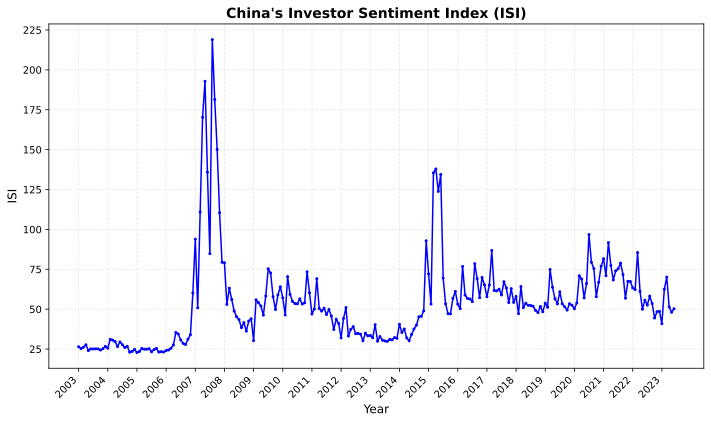

In [15]:
# 筛选时间范围：2003-01 至 2023-06
plot_data = reg_data.loc['2003-01':'2023-06']

# 创建图形
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制 ISI 折线图
ax.plot(
    plot_data.index,        # x轴：月份索引
    plot_data['ISI'],       # y轴：ISI 值
    linewidth=1.5,          # 线宽
    color='blue',           # 颜色：蓝色
    marker='o',             # 标记：圆点
    markersize=2            # 标记大小
)

# 设置标题和轴标签
plt.title("China's Investor Sentiment Index (ISI)", fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('ISI', fontsize=12)

# 设置 x 轴刻度：只显示年份，每3年显示一次
years = pd.date_range(start='2003-01-01', end='2023-12-31', freq='YS')
ax.set_xticks([yr.strftime('%Y-%m') for yr in years])
ax.set_xticklabels([yr.strftime('%Y') for yr in years])

# 旋转 x 轴标签
plt.xticks(rotation=45, ha='right')

# 添加网格
plt.grid(True, alpha=0.3, linestyle='--')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show();

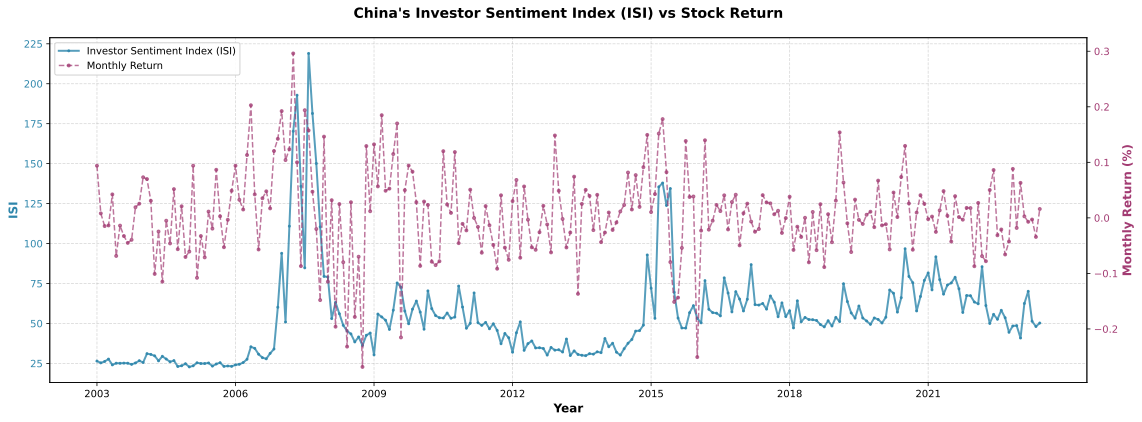

In [16]:
# 筛选数据时间范围
plot_data = reg_data.loc['2003-01':'2023-06']

# 创建图形和子图
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 1, 1)

# 绘制 ISI（左边y轴）- 使用渐变色
ax1.plot(plot_data.index,
         plot_data['ISI'],
         color='#2E86AB',      # 深蓝色
         marker='.',
         linestyle='-',
         linewidth=2,
         markersize=4,
         alpha=0.8,
         label='Investor Sentiment Index (ISI)')

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('ISI', fontsize=12, fontweight='bold', color='#2E86AB')
ax1.set_title("China's Investor Sentiment Index (ISI) vs Stock Return", 
             fontsize=14, fontweight='bold', pad=20)
ax1.tick_params(axis='y', labelcolor='#2E86AB')

# 创建右边y轴 - 显示收益率
ax2 = ax1.twinx()
ax2.plot(plot_data.index,
         plot_data['ret'],
         color='#A23B72',      # 紫红色
         marker='o',
         linestyle='--',
         linewidth=1.5,
         markersize=3,
         alpha=0.7,
         label='Monthly Return')

ax2.set_ylabel('Monthly Return (%)', fontsize=12, fontweight='bold', color='#A23B72')
ax2.tick_params(axis='y', labelcolor='#A23B72')

# 设置 x 轴刻度：每3年显示一次
x_ticks = pd.date_range(start='2003-01-01', end='2023-12-31', freq='3YS')
ax1.set_xticks([yr.strftime('%Y-%m') for yr in x_ticks])
ax1.set_xticklabels([yr.strftime('%Y') for yr in x_ticks])

# 旋转 x 轴标签
plt.xticks(rotation=45, ha='right')

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', framealpha=0.9)

# 添加网格
ax1.grid(True, alpha=0.3, linestyle='--', color='gray')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show();


In [17]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月收益率数据进行ADF检验
adf_result = ADF(reg_data[reg_data.index >= '2000-01-31']['ISI'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -4.3394
p-value: 0.0004
Critical Values:
   1%: -3.4579
   5%: -2.8737
   10%: -2.5732
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [ ]:
reg_data['lpd'] = reg_data['ISI'].shift(1)
model_fore_pd = smf.ols('ret ~ lpd',
                 data=reg_data['2003-01':'2023-06']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_fore_pd.summary())

In [18]:
reg_data

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q,ISI
month,,,,,,,,,,
2003-01,0.095492,0.102435,0.001635,0.093857,0.100800,0.086691,0.040623,-0.049744,2003 Q1,26.44
2003-02,0.009710,0.014786,0.001635,0.008075,0.013151,-0.020474,-0.062751,-0.068131,2003 Q1,25.30
2003-03,-0.013132,-0.025631,0.001635,-0.014767,-0.027266,0.012865,-0.101020,-0.009918,2003 Q1,26.20
2003-04,-0.012054,-0.042101,0.001635,-0.013689,-0.043736,-0.042592,-0.128884,0.036608,2003 Q2,27.69
2003-05,0.043905,0.040771,0.001635,0.042270,0.039136,-0.042843,-0.151914,-0.056693,2003 Q2,24.05
...,...,...,...,...,...,...,...,...,...,...
2023-02,0.004072,0.032681,0.001365,0.002707,0.031316,-0.007326,0.008473,-0.181302,2023 Q1,62.48
2023-03,-0.005681,-0.015159,0.001365,-0.007046,-0.016524,-0.044072,-0.051919,-0.112533,2023 Q1,70.10
2023-04,-0.001596,-0.029947,0.001365,-0.002961,-0.031312,-0.021863,-0.051844,-0.092017,2023 Q2,51.39


In [19]:
import pandas as pd
import statsmodels.api as sm

# 1. 读取数据（替换为你的文件路径）
data = reg_data  # 假设数据包含Y和X列，索引为月份

# 2. 构建回归模型（添加常数项C，EViews默认包含常数项）
X = data['ISI']  # 解释变量：投资者情绪综合指数
X = sm.add_constant(X)  # 添加常数项（对应EViews中的C）
Y = data['ret']  # 被解释变量：上证综指月收益率

# 3. 执行OLS回归
model = sm.OLS(Y, X).fit()  # 拟合模型

# 4. 输出回归结果（与EViews格式一致）
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     12.02
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           0.000620
Time:                        15:49:40   Log-Likelihood:                 283.98
No. Observations:                 246   AIC:                            -564.0
Df Residuals:                     244   BIC:                            -556.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0241      0.010     -2.304      0.0

回归方程为：ret= -0.0241 + 0.0006ISI
表明投资者情绪指数（ISI）对股票收益率（ret）有显著正向影响（ISI 系数为 0.0006，P 值 = 0.001<0.05），即 ISI 每提高 1 单位，股票收益率平均增加 0.0006 单位。
模型拟合结果为：R²=0.047，说明 ISI 能解释 4.7% 的股票收益率变化（拟合度低于原文档，可能因样本区间或变量定义不同）。
F 统计量 = 12.02，P 值 = 0.000620<0.05，表明模型整体显著，即 ISI 对股票收益率的影响在统计上可信。
Durbin-Watson 值 = 1.766，接近 2，说明残差无显著自相关（模型假设更满足）。
常数项 C 的系数为 - 0.0241（P 值 = 0.022<0.05），表明当 ISI 为 0 时，股票收益率的基准水平为 - 0.0241。
因此：该模型可决系数较高，F 检验值为12.02，说明投资
者情绪对股票收益率确有影响。且投资者情绪对股票收益
率的影响为正向。

结论如下：
投资者情绪对我国股票收益率产生正向影响，当投资者投资积极性高时，股票收益率趋于提高；反之股票收益率趋于降低。

对此，提出以下建议：
1.健全市场监管制度。
2.优化投资者结构。
3.引导投资者理性投资，减少投资者的非理性投资。